# Guitar Basic Chord Classification Using CNN

**Objective** : This notebook's main focus will be on how to use CNN and Keras to categorize photos of the hand position used to create the guitar's fundamental chord. We want to know the following things in particular.

- **How accurately does CNN classify images?**
- **Which images are best for classification: grayscale, or colored?**
- **What is the best activation function used in the hidden layer?: relu or tanh**

### Import Libraries

1. **Library matplotlib, seaborn** required for **image visualization**.
2. **Library tensorflow,keras** required for **modelling and load the images**.
3. **Sklearn** required for **evaluate the models**.
4. **Pillow** required for **extract metadata of images**

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image
import numpy as np

### Load Data

In [2]:
trainPath = '../Data/train/'
valPath = '../Data/val/'
testPath = '../Data/test/'

In [3]:
#Training
train = tf.keras.utils.image_dataset_from_directory(trainPath,
                                                            labels='inferred',
                                                            label_mode='categorical',
                                                            shuffle=True)

#Validation
validation = tf.keras.utils.image_dataset_from_directory(valPath,
                                                            labels='inferred',
                                                            label_mode='categorical',
                                                            shuffle=True)

#Test
test = tf.keras.utils.image_dataset_from_directory(testPath,
                                                            labels='inferred',
                                                            label_mode='categorical',
                                                            shuffle=True)

Found 1059 files belonging to 7 classes.
Found 140 files belonging to 7 classes.
Found 215 files belonging to 7 classes.


### Let's explore the dataset

Here's some questions:

- How many training,testing and validation examples do we have ?
- What is the size of the images ?
- What is the proportion of each observed category ?

In [4]:
n_train = len(np.concatenate([i for x, i in train], axis=0))
n_test = len(np.concatenate([i for x, i in test], axis=0))
n_valid = len(np.concatenate([i for x, i in validation], axis=0))


print("Train Num      : ", n_train)
print("Test Num       : ", n_test)
print("Validation Num : ", n_valid)

Train Num      :  1059
Test Num       :  215
Validation Num :  140


In [5]:
def metadata(image):
    image = Image.open(image)

    info_dict = {
    "Image Size": image.size,
    "Image Height": image.height,
    "Image Width": image.width,
    "Image Format": image.format,
    "Image Mode": image.mode,
    }

    for label,value in info_dict.items():
        print(f"{label:25}: {value}")


imageTrain = '../Data/train/A/IMG_0340.jpeg'
imageTest = '../Data/test/A/IMG_0336.jpeg'
imageVal = '../Data/val/A/IMG_0349.jpeg'

print("Data Train")
metadata(imageTrain)

print("\nData Test")
metadata(imageTrain)

print("\nData Validation")
metadata(imageTrain)

Data Train
Image Size               : (4032, 3024)
Image Height             : 3024
Image Width              : 4032
Image Format             : JPEG
Image Mode               : RGB

Data Test
Image Size               : (4032, 3024)
Image Height             : 3024
Image Width              : 4032
Image Format             : JPEG
Image Mode               : RGB

Data Validation
Image Size               : (4032, 3024)
Image Height             : 3024
Image Width              : 4032
Image Format             : JPEG
Image Mode               : RGB


In [6]:
# class names
class_names = os.listdir(trainPath)
print('All category : ',class_names)

All category :  ['A', 'B', 'C', 'D', 'E', 'F', 'G']


In [7]:
def countImage(path):
    count  = []
    for x in os.listdir(path):
        count.append(len(os.listdir(path + x)))
    return count


trainCount = countImage('../Data/train/')
testCount = countImage('../Data/test/')
valCount = countImage('../Data/val/')


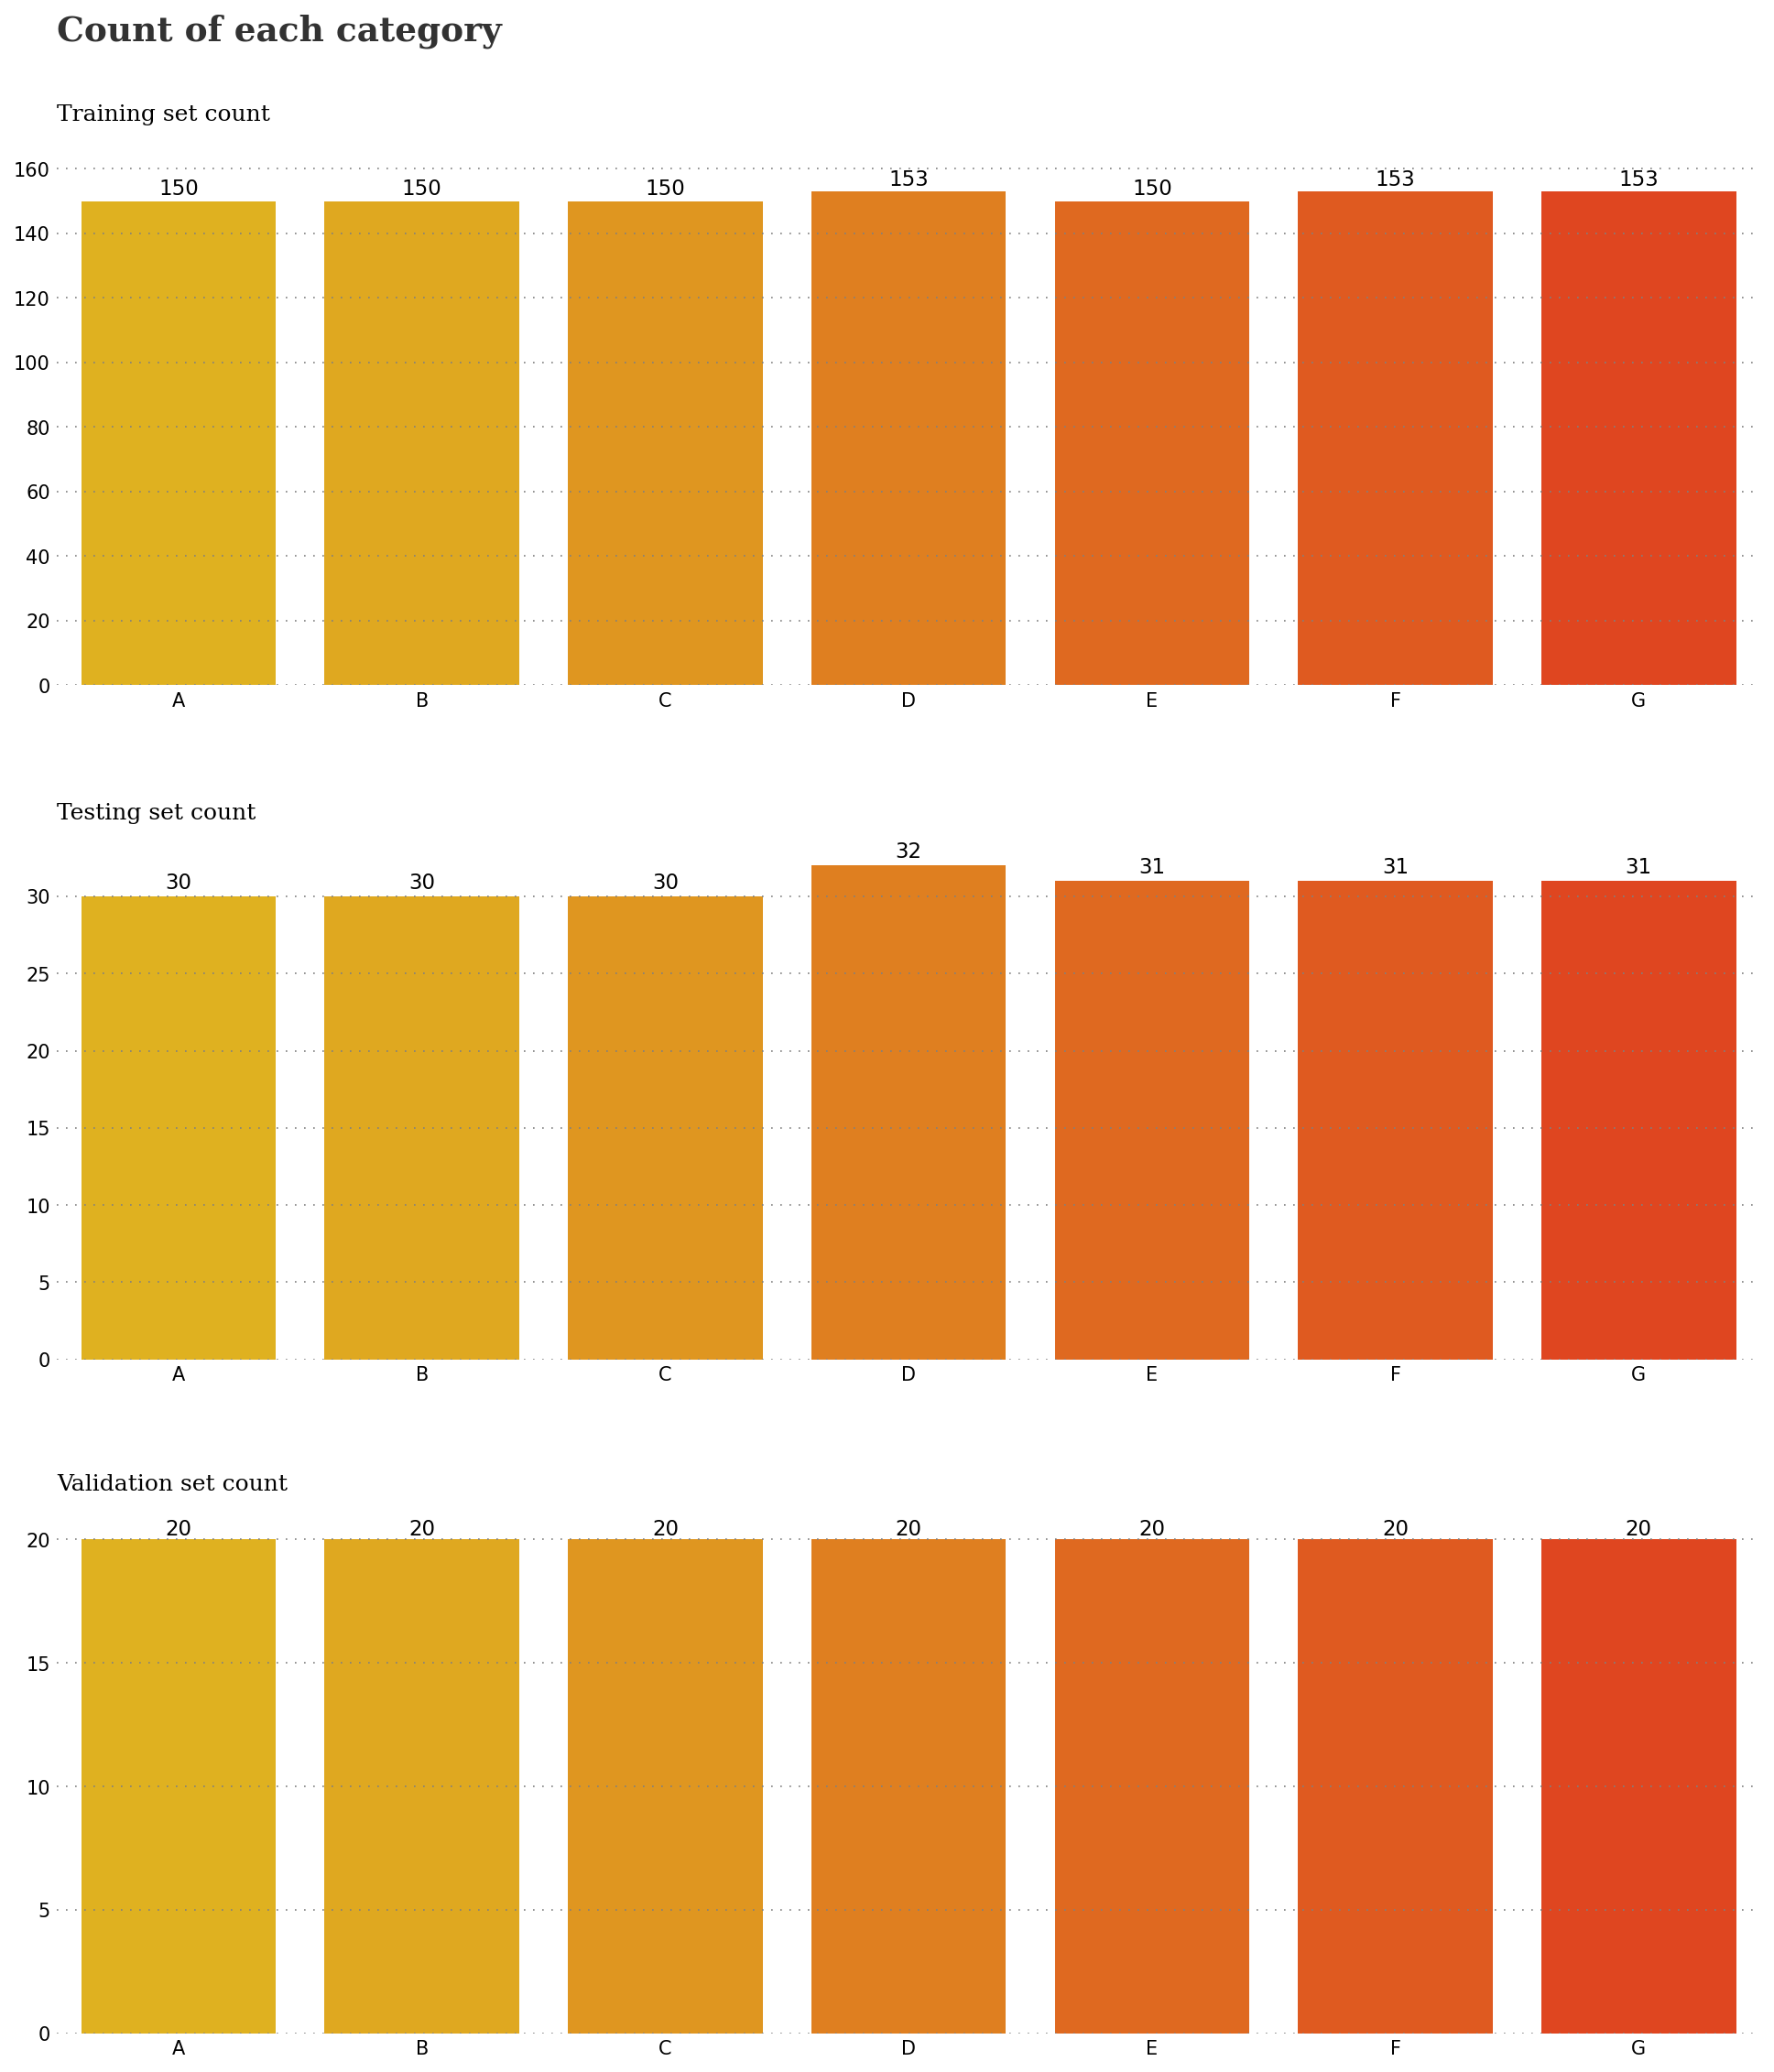

In [8]:
custom_palette = ['#ffc100','#ffb600','#ff9e00','#ff7f00','#ff6100','#ff4d00','#ff3300']
sns.set_palette(custom_palette)


fig = plt.figure(figsize=(16, 18), dpi=150)

gs = fig.add_gridspec(3, 1)
gs.update(wspace=0.4, hspace=0.3)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[2, 0])

#AX0 - Data Train
ax0.text(-0.5, 200, 'Count of each category', fontsize=18,
         fontweight='bold', fontfamily='serif', color="#323232")
ax0.text(-0.5, 175, 'Training set count',
         fontfamily='serif', fontsize=12, fontweight='light')
sns.barplot(x=class_names,y=trainCount, ax=ax0)
for i in range(7):
    ax0.annotate(f'{trainCount[i]}', 
                    xy =(i, trainCount[i]+2),
                    color='black',
                    horizontalalignment='center',
                    fontsize=11,
                    fontweight='light'
                    )

#AX1 - Data Test
ax1.text(-0.5, 35, 'Testing set count',
         fontfamily='serif', fontsize=12, fontweight='light')
sns.barplot(x=class_names,y=testCount, ax=ax1)
for i in range(7):
    ax1.annotate(f'{testCount[i]}', 
                    xy =(i, testCount[i]+0.5),
                    color='black',
                    horizontalalignment='center',
                    fontsize=11,
                    fontweight='light'
                    )



ax2.text(-0.5, 22, 'Validation set count',
         fontfamily='serif', fontsize=12, fontweight='light')
sns.barplot(x=class_names,y=valCount, ax=ax2)
for i in range(7):
    ax2.annotate(f'{valCount[i]}', 
                    xy =(i, valCount[i]+0.2),
                    color='black',
                    horizontalalignment='center',
                    fontsize=11,
                    fontweight='light'
                    )
ax2.set_yticks([0,5,10,15,20])

for s in ["top", "right",'left','bottom']:
    for i in range(0, 3):
        locals()["ax"+str(i)].spines[s].set_visible(False)

for i in range(0, 3):
    locals()["ax"+str(i)].tick_params(axis=u'both', which=u'both', length=0)
    locals()["ax"+str(i)].grid(color='gray', linestyle=':',
                               axis='y', zorder=0,  dashes=(1, 5))

**Key take points**:
- **Training set** has the most amount of images, as expected
- The image has the size of **(4032, 3024)**, we can resize it later
- There were 8 category, as expected
- The proportion of each category in the training set is relatively balance, as expected

#### Visualize the data
We can display a random image from the training set.

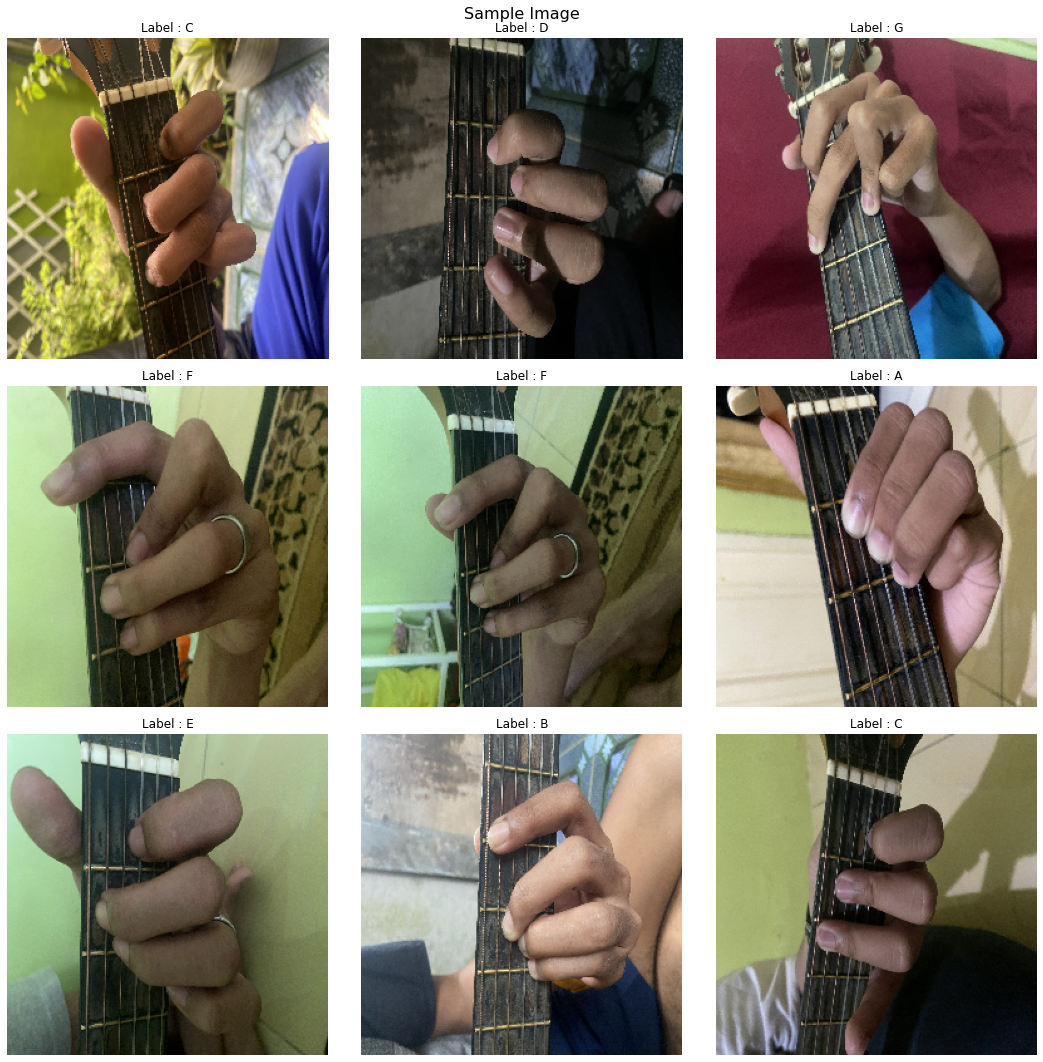

In [9]:
plt.figure(figsize=(15, 15))
class_names = test.class_names
for images, labels in test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f'Label : {class_names[tf.argmax(labels[i])]}')
        plt.axis("off")

plt.suptitle('Sample Image',fontsize='16')
plt.tight_layout()


### Lets preprocess the image
Here's what we're gonna do in preprocessing:
- **Resize**            : To improve computational efficiency and ensure consistency across images.
- **Adjust Brightness** : To improve visibility of the image and to create a more uniform brightness across the entire image
- **Adjust Saturation** : To enhance color in the image
- **Normalization**     : Ensures that each input parameter (pixel, in this case) has a similar data distribution

In [46]:
# Function to take sample before and after enhancement
def sample_img(image1, image2):
    plt.figure(figsize=(10,10))

    plt.subplot(1, 2, 1)
    plt.title("Before")
    plt.imshow(image1.numpy().astype("uint8"))
    plt.axis(False)

    plt.subplot(1, 2, 2)
    plt.title("After")
    plt.imshow(image2.numpy().astype("uint8"))
    plt.axis(False)


for images, labels in train.take(1):
    sample_image = images[1]


**Resize**

In [11]:
def resize(image,label):
    return tf.image.resize(image,[256,256]),label

**Adjust Brightness**

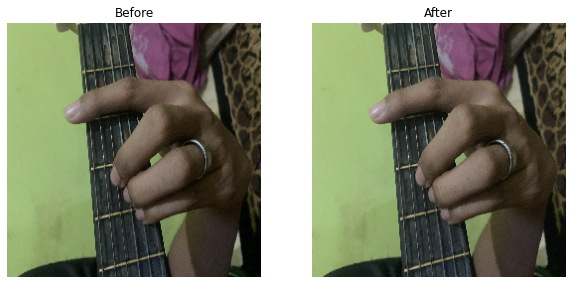

In [50]:
def brightness(image,label):
    return tf.image.adjust_brightness(image,delta = 5),label

sample_img(sample_image, tf.image.adjust_brightness(sample_image,delta = 5))

**Adjust Saturation**

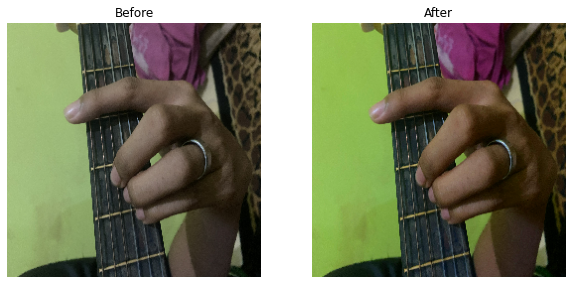

In [51]:
def saturation(image,label):
    return tf.image.adjust_saturation(image,saturation_factor = 1.6),label


sample_img(sample_image, tf.image.adjust_saturation(sample_image,saturation_factor = 1.6))

**Normalize**

In [14]:
def normalize(image,label):
    return tf.cast(image,tf.float32) / 255.0,label

Let's combine it into one pipeline

In [15]:
def preprocessing_pipeline(image,label):
    image,label = resize(image,label)

    image,label = brightness(image,label)

    image,label = saturation(image,label)

    image,label = normalize(image,label)

    return image,label

train = train.map(preprocessing_pipeline)
test = test.map(resize).map(normalize)
validation = validation.map(resize).map(normalize)

**Grayscalling**

Convert images to grayscale and save it to a temporary variable to be used in modelling later

In [16]:
def grayScale(images,label):
    return tf.image.rgb_to_grayscale(images),label
    

train_grayscale = train.map(grayScale)
test_grayscale = test.map(grayScale)
validation_grayscale = validation.map(grayScale)

### Modelling
We'll do the modelling four times, each time with a different activation function:
- RGB - RELU
- RGB - TANH
- GrayScale - Relu
- GrayScale - Tanh

In [17]:
earlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
)

In [18]:
def model(train_set,validation_set,test_set,activation,image_channels):
    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                           input_shape=(256, 256, image_channels)),  

    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation=activation),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation=activation),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation=activation),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(64, activation=activation),
    tf.keras.layers.Dense(7, activation='softmax')  
    ])

    model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics=['accuracy'])
    results = model.fit(train_set, epochs=30,batch_size=32,validation_data=validation_set,verbose=1,callbacks=[earlyStopping])
    test_evaluate = model.evaluate(test_set,verbose =0)

    return model,results,test_evaluate


**RGB - RELU**

In [19]:
rgb_relu_model,rgb_relu_result,rgba_relu_evaluate = model(train,validation,test,'relu',3)

Epoch 1/30
34/34 [==============================] - 115s 3s/step - loss: 1.8826 - accuracy: 0.2417 - val_loss: 1.9001 - val_accuracy: 0.2571
Epoch 2/30
34/34 [==============================] - 107s 3s/step - loss: 1.3505 - accuracy: 0.4806 - val_loss: 1.6171 - val_accuracy: 0.5143
Epoch 3/30
34/34 [==============================] - 105s 3s/step - loss: 0.7840 - accuracy: 0.7214 - val_loss: 0.8956 - val_accuracy: 0.6714
Epoch 4/30
34/34 [==============================] - 108s 3s/step - loss: 0.4257 - accuracy: 0.8555 - val_loss: 0.6266 - val_accuracy: 0.8000
Epoch 5/30
34/34 [==============================] - 109s 3s/step - loss: 0.2818 - accuracy: 0.9112 - val_loss: 0.7632 - val_accuracy: 0.7643
Epoch 6/30
34/34 [==============================] - 110s 3s/step - loss: 0.1589 - accuracy: 0.9509 - val_loss: 0.6779 - val_accuracy: 0.8000
Epoch 7/30
34/34 [==============================] - 98s 3s/step - loss: 0.1556 - accuracy: 0.9481 - val_loss: 0.8360 - val_accuracy: 0.7929
Epoch 8/30
34/

**RGB - TANH**

In [26]:
rgb_tanh_model,rgb_tanh_result,rgba_tanh_evaluate = model(train,validation,test,'tanh',3)

Epoch 1/30
34/34 [==============================] - 102s 3s/step - loss: 2.8095 - accuracy: 0.2805 - val_loss: 2.4380 - val_accuracy: 0.2214
Epoch 2/30
34/34 [==============================] - 108s 3s/step - loss: 1.7077 - accuracy: 0.4230 - val_loss: 1.2593 - val_accuracy: 0.6000
Epoch 3/30
34/34 [==============================] - 112s 3s/step - loss: 1.0050 - accuracy: 0.6591 - val_loss: 0.9069 - val_accuracy: 0.6929
Epoch 4/30
34/34 [==============================] - 110s 3s/step - loss: 0.6810 - accuracy: 0.7677 - val_loss: 0.9073 - val_accuracy: 0.7071
Epoch 5/30
34/34 [==============================] - 114s 3s/step - loss: 0.5120 - accuracy: 0.8555 - val_loss: 0.7397 - val_accuracy: 0.7571
Epoch 6/30
34/34 [==============================] - 110s 3s/step - loss: 0.3503 - accuracy: 0.9273 - val_loss: 0.6417 - val_accuracy: 0.7929
Epoch 7/30
34/34 [==============================] - 108s 3s/step - loss: 0.2584 - accuracy: 0.9509 - val_loss: 0.4990 - val_accuracy: 0.8286
Epoch 8/30
34

**GRAYSCALE - RELU**

In [21]:
grayscale_relu_model,grayscale_relu_result,grayscale_relu_evaluate = model(train_grayscale,validation_grayscale,test_grayscale,'relu',1)

Epoch 1/30
34/34 [==============================] - 96s 3s/step - loss: 1.7274 - accuracy: 0.2965 - val_loss: 1.3212 - val_accuracy: 0.5357
Epoch 2/30
34/34 [==============================] - 93s 3s/step - loss: 0.9592 - accuracy: 0.6686 - val_loss: 0.5849 - val_accuracy: 0.7857
Epoch 3/30
34/34 [==============================] - 96s 3s/step - loss: 0.5377 - accuracy: 0.8187 - val_loss: 0.6310 - val_accuracy: 0.7857
Epoch 4/30
34/34 [==============================] - 78s 2s/step - loss: 0.3262 - accuracy: 0.8980 - val_loss: 0.4725 - val_accuracy: 0.8286
Epoch 5/30
34/34 [==============================] - 72s 2s/step - loss: 0.2106 - accuracy: 0.9339 - val_loss: 0.4963 - val_accuracy: 0.8286
Epoch 6/30
34/34 [==============================] - 73s 2s/step - loss: 0.2157 - accuracy: 0.9330 - val_loss: 0.5672 - val_accuracy: 0.8286
Epoch 7/30
34/34 [==============================] - 73s 2s/step - loss: 0.0872 - accuracy: 0.9688 - val_loss: 0.5034 - val_accuracy: 0.8786
Epoch 8/30
34/34 [==

**GRAYSCALE - TANH**

In [22]:
grayscale_tanh_model,grayscale_relu_result,grayscale_tanh_evaluate = model(train_grayscale,validation_grayscale,test_grayscale,'tanh',1)

Epoch 1/30
34/34 [==============================] - 75s 2s/step - loss: 1.9259 - accuracy: 0.3390 - val_loss: 1.3765 - val_accuracy: 0.4786
Epoch 2/30
34/34 [==============================] - 75s 2s/step - loss: 1.0752 - accuracy: 0.6213 - val_loss: 0.7871 - val_accuracy: 0.7286
Epoch 3/30
34/34 [==============================] - 75s 2s/step - loss: 0.6613 - accuracy: 0.7602 - val_loss: 0.5692 - val_accuracy: 0.8071
Epoch 4/30
34/34 [==============================] - 75s 2s/step - loss: 0.3323 - accuracy: 0.8999 - val_loss: 0.4832 - val_accuracy: 0.8429
Epoch 5/30
34/34 [==============================] - 74s 2s/step - loss: 0.2443 - accuracy: 0.9320 - val_loss: 0.4229 - val_accuracy: 0.8714
Epoch 6/30
34/34 [==============================] - 74s 2s/step - loss: 0.1286 - accuracy: 0.9726 - val_loss: 0.4213 - val_accuracy: 0.8571
Epoch 7/30
34/34 [==============================] - 75s 2s/step - loss: 0.0877 - accuracy: 0.9773 - val_loss: 0.3536 - val_accuracy: 0.8643
Epoch 8/30
34/34 [==

### Evaluate
For the model's evaluation, we'll do the following:
1. Evaluate the test set
2. Graph for each epoch
3. Confusion Matrix
4. Accuration Report
5. Predict random image

**Evalute Test Set**:
Here, we'll look at how accurate each model is with a test set.

In [29]:
print("======== RGB - RELU ===============")
print(f'Test loss     : {rgba_relu_evaluate[0]}')
print(f'Test accuracy : {round(rgba_relu_evaluate[1],2)}')


print("\n======== RGB - TANH ===============")
print(f'Test loss     : {rgba_tanh_evaluate[0]}')
print(f'Test accuracy : {round(rgba_tanh_evaluate[1],2)}')

print("\n======== GRAYSCALE - RELU ===============")
print(f'Test loss     : {grayscale_relu_evaluate[0]}')
print(f'Test accuracy : {round(grayscale_relu_evaluate[1],2)}')

print("\n======== GRAYSCALE - TANH ===============")
print(f'Test loss     : {grayscale_relu_evaluate[0]}')
print(f'Test accuracy : {round(grayscale_relu_evaluate[1],2)}')

======== RGB - RELU ===============
Test loss     : 0.5159609913825989
Test accuracy : 0.82

======== RGB - TANH ===============
Test loss     : 0.3030170798301697
Test accuracy : 0.92

======== GRAYSCALE - RELU ===============
Test loss     : 0.39862698316574097
Test accuracy : 0.87

======== GRAYSCALE - TANH ===============
Test loss     : 0.39862698316574097
Test accuracy : 0.87


**Key Points**:
- Given that each category is balanced in this case, accuracy is used as the evaluation metric.
- RGB - TANH is the best model to peform given that its has the best accuracy
- Yet given that any other model's accuracy is greater than 80%, it is safe to state that it performs well.

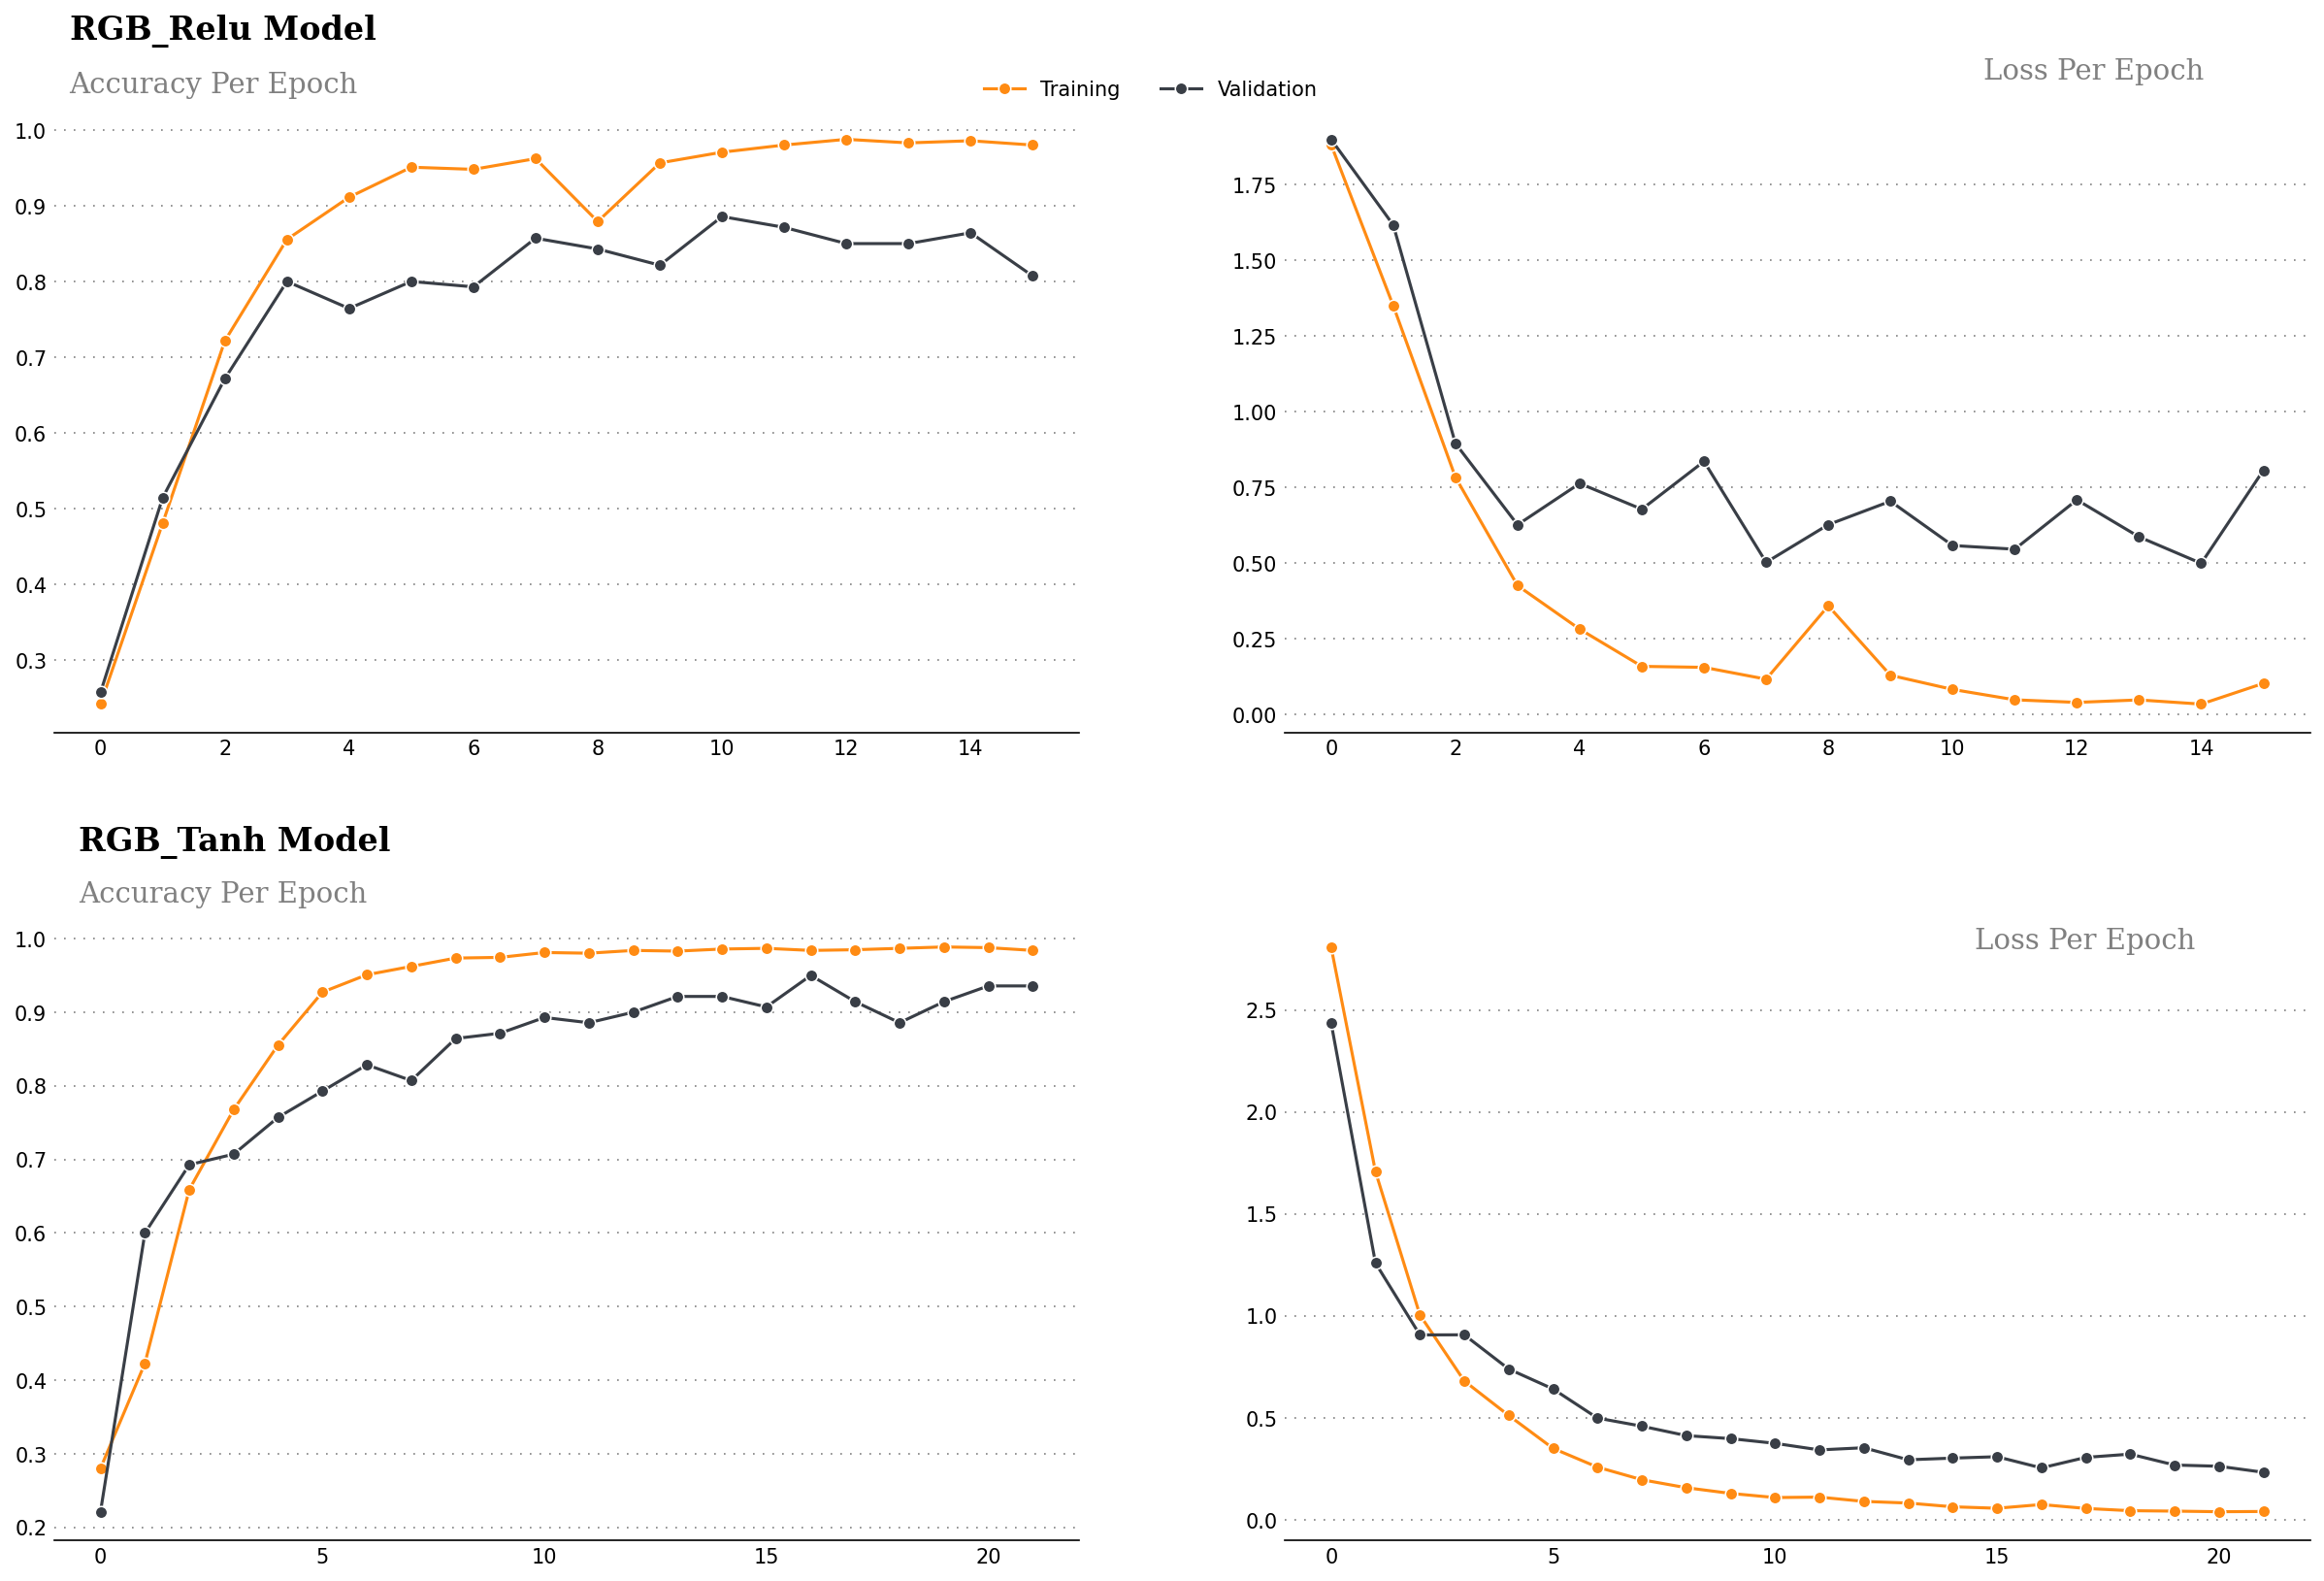

In [63]:
fig = plt.figure(figsize=(20,13), dpi=150)

palette = ["#FF8B13","#393E46"]

#Acquaire history from rgb_relu
len_rgb_relu = len(rgb_relu_result.history['accuracy'])
accuracy_rgb_relu = rgb_relu_result.history['accuracy']
valaccuracy_rgb_relu = rgb_relu_result.history['val_accuracy']

loss_rgb_relu = rgb_relu_result.history['loss']
val_loss_rgb_relu = rgb_relu_result.history['val_loss']

#Acquaire history from rgb_tanh
len_tanh_relu = len(rgb_tanh_result.history['accuracy'])
accuracy_tanh_relu = rgb_tanh_result.history['accuracy']
val_accuracy_tanh_relu = rgb_tanh_result.history['val_accuracy']

loss_rgb_tanh = rgb_tanh_result.history['loss']
val_loss_rgb_tanh = rgb_tanh_result.history['val_loss']

gs = fig.add_gridspec(2, 2)
gs.update(hspace=0.3)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])


#Lineplot RGB-RELU (Accuracy)
ax0.text(-0.5, 1.12,"RGB_Relu Model",fontsize=16, fontweight='bold',fontfamily='serif')
ax0.text(-0.5, 1.05,"Accuracy Per Epoch",fontsize=14, fontweight='light',color='gray',fontfamily='serif')
ax0_x_ticks = np.arange(0, len_rgb_relu)
ax0.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.lineplot(x=ax0_x_ticks,y=accuracy_rgb_relu,ax=ax0,label='Training',color=palette[0],marker='o')
sns.lineplot(x=ax0_x_ticks,y=valaccuracy_rgb_relu,ax=ax0,label='Validation',color=palette[1],marker='o')

legend_labels, _= ax0.get_legend_handles_labels()
ax0.legend(legend_labels, ["Training", "Validation"], ncol=2, bbox_to_anchor=(1.25, 1.08), edgecolor='white')


#Lineplot RGB-RELU (Loss)
ax1.text(10.5, 2.1,"Loss Per Epoch",fontsize=14, fontweight='light',color='gray',fontfamily='serif')
ax1_x_ticks = np.arange(0, len_rgb_relu)
ax1.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.lineplot(x=ax0_x_ticks,y=loss_rgb_relu,ax=ax1,label='Training',color=palette[0],marker='o')
sns.lineplot(x=ax0_x_ticks,y=val_loss_rgb_relu,ax=ax1,label='Validation',color=palette[1],marker='o')
ax1.get_legend().remove()


#Lineplot RGB-TANH (Accuracy)
rgb_tanh_ticks = np.arange(0, len_tanh_relu)
ax2.text(-0.5, 1.12,"RGB_Tanh Model",fontsize=16, fontweight='bold',fontfamily='serif')
ax2.text(-0.5, 1.05,"Accuracy Per Epoch",fontsize=14, fontweight='light',color='gray',fontfamily='serif')
ax2_x_ticks = np.arange(0, len_rgb_relu)
ax2.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.lineplot(x=rgb_tanh_ticks,y=accuracy_tanh_relu,ax=ax2,label='Training',color=palette[0],marker='o')
sns.lineplot(x=rgb_tanh_ticks,y=val_accuracy_tanh_relu,ax=ax2,label='Validation',color=palette[1],marker='o')
ax2.get_legend().remove()

#Lineplot RGB-TANH (Loss)
rgb_tanh_ticks = np.arange(0, len_tanh_relu)
ax3.text(14.5, 2.8,"Loss Per Epoch",fontsize=14, fontweight='light',color='gray',fontfamily='serif')
ax2_x_ticks = np.arange(0, len_rgb_relu)
ax3.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.lineplot(x=rgb_tanh_ticks,y=loss_rgb_tanh,ax=ax3,label='Training',color=palette[0],marker='o')
sns.lineplot(x=rgb_tanh_ticks,y=val_loss_rgb_tanh,ax=ax3,label='Validation',color=palette[1],marker='o')
ax3.get_legend().remove()


for s in ["top","right","left"]:
    for i in range(0,4):
        locals()["ax"+str(i)].spines[s].set_visible(False)
        locals()["ax"+str(i)].tick_params(axis=u'both', which=u'both',length=0)

NameError: name 'hasil' is not defined

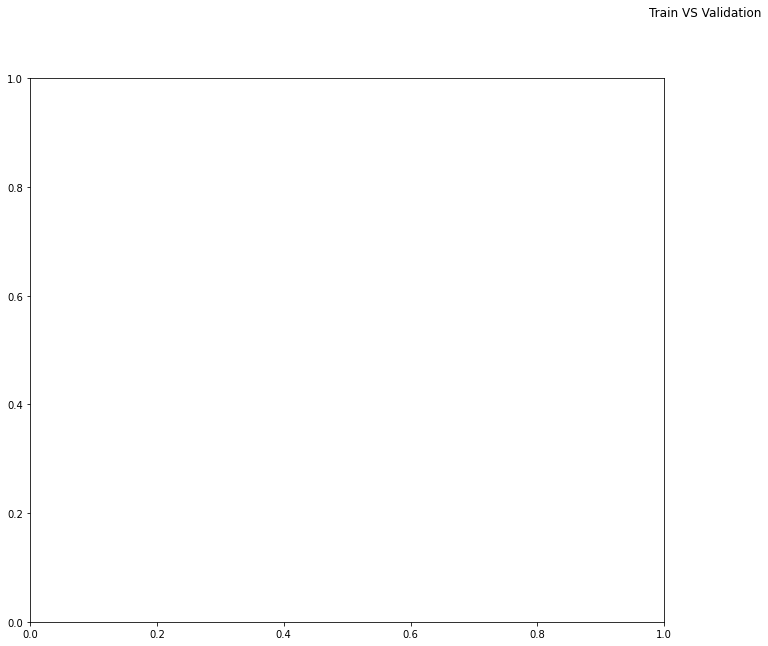

In [25]:
epoch = [i+1 for i in range(30)]


plt.figure(figsize=(25, 10))
plt.suptitle('Train VS Validation')

#Subplot Akurasi
plt.subplot(1,2,1)
sns.lineplot(x=epoch,y = hasil.history['accuracy'],label ='Train Accuracy')
sns.lineplot(x=epoch,y = hasil.history['val_accuracy'],label ='Validation Accuracy')

plt.xticks(epoch)
plt.ylabel('Accuracy(%)')
plt.xlabel('N_Epoch')
plt.title("Train/Validation Accuracy")

#Subplot Loss
plt.subplot(1,2,2)
sns.lineplot(x=epoch,y = hasil.history['loss'],label ='Train Loss')
sns.lineplot(x=epoch,y = hasil.history['val_loss'],label ='Validation Loss')

plt.xticks(epoch)
plt.title("Train/Validation Loss")
plt.xlabel('N_Epoch')
plt.ylabel('Loss')
plt.show()


#### Preview hasil prediksi

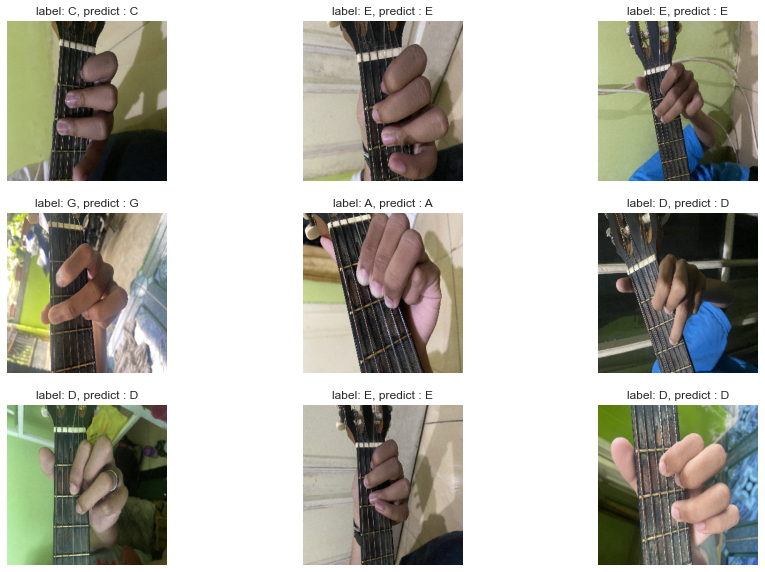

In [ ]:
image ,label = next(iter(test))

plt.figure(figsize=(15,10))
for i in range(9) :
    TrueLabel = class_names[np.argmax(label[i])]
    plt.subplot(3,3,i+1)
    plt.axis('off')
    y_pred = np.argmax(model.predict(image[i][None,...],verbose=0))
    plt.imshow(tf.squeeze(image[i]))
    plt.title(f'label: {TrueLabel}, predict : {class_names[y_pred]}')

#### Preview prediction error

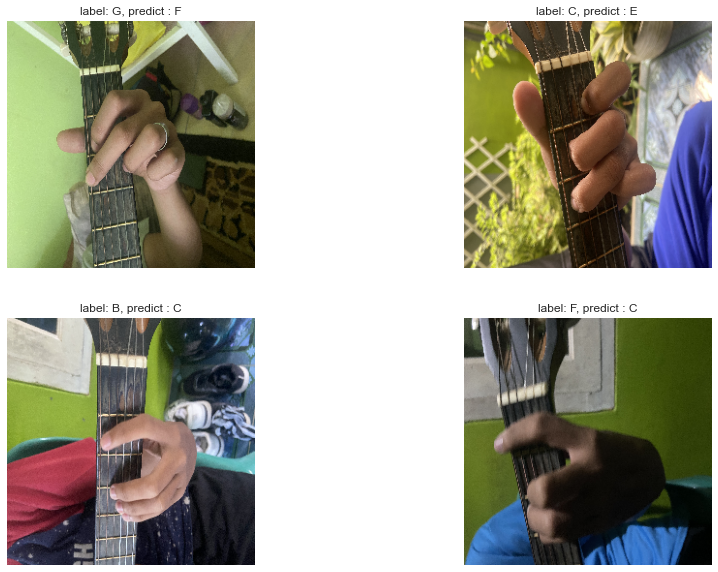

In [ ]:
#Plot prediction Error
image ,label = next(iter(test))
plt.figure(figsize=(15,10))
i,j = 0,0
while (j < 4):
    TrueLabel = class_names[np.argmax(label[i])]
    plt.subplot(2,2,j+1)
    plt.axis('off')
    y_pred = np.argmax(model.predict(image[i][None,...],verbose=0))
    if (TrueLabel != class_names[y_pred]):
        plt.imshow(tf.squeeze(image[i]))
        plt.title(f'label: {TrueLabel}, predict : {class_names[y_pred]}')
        j+=1
    i+=1

#### Confusion Matrix

In [ ]:
y_test = []
y_pred = []

for i in range(len(test)) :
    x,y = test.next()
    for j in range(len(y)) :
        y_test.append(class_names[tf.argmax(y[j])])
        y_pred.append(class_names[np.argmax(model.predict(x[j][None,...],verbose=0))])

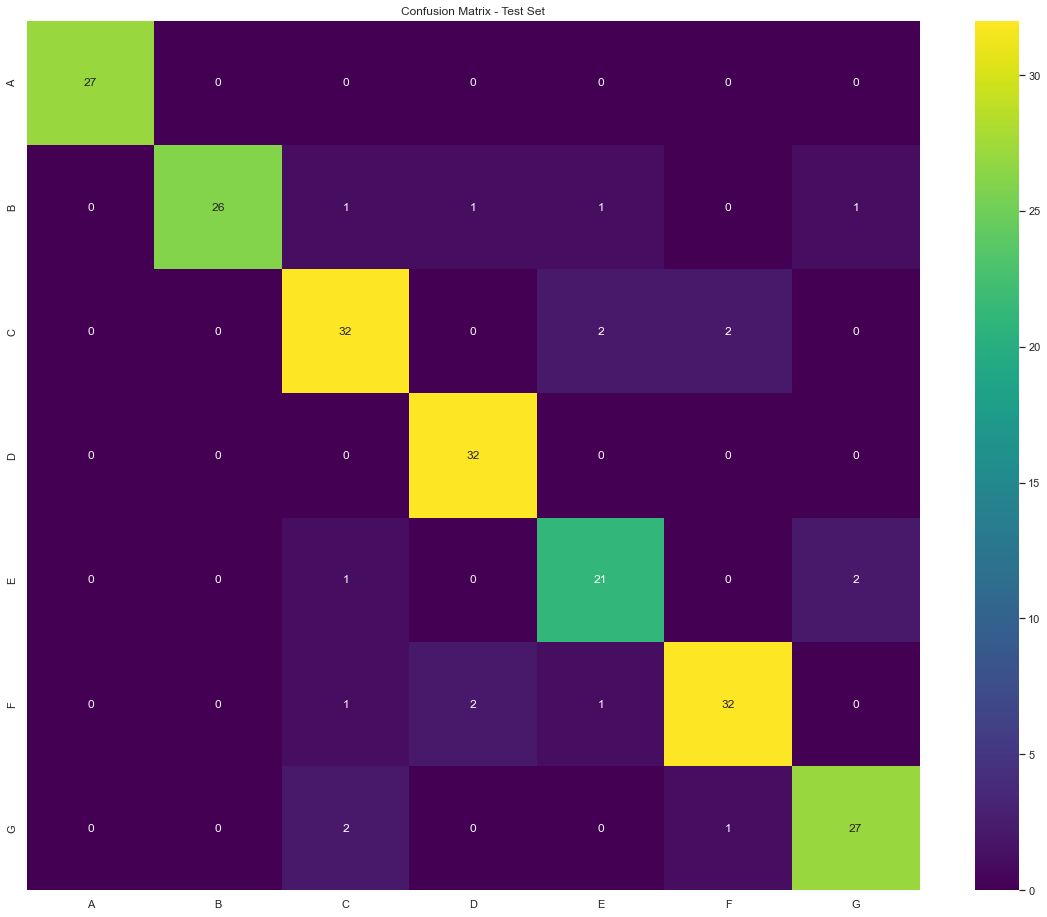

In [ ]:
plt.figure(figsize=(20, 16))
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm,annot=True,fmt='d',xticklabels=class_names,yticklabels=class_names,cmap='viridis')
plt.title("Confusion Matrix - Test Set")
plt.show()

### Classification Report

In [ ]:

print('Classification Report')
print(classification_report(y_test, y_pred, target_names=class_names))

Classification Report
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        27
           B       1.00      0.87      0.93        30
           C       0.86      0.89      0.88        36
           D       0.91      1.00      0.96        32
           E       0.84      0.88      0.86        24
           F       0.91      0.89      0.90        36
           G       0.90      0.90      0.90        30

    accuracy                           0.92       215
   macro avg       0.92      0.92      0.92       215
weighted avg       0.92      0.92      0.92       215

